# Create Geometry

In [1]:
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.autograd import grad

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

torch.set_default_dtype(torch.float64)

In [2]:
class Shape:
    def __init__(self, node_capacity):
        self.x  = np.empty(node_capacity)
        self.y  = np.empty(node_capacity)
        self.z  = np.empty(node_capacity)
        self.T0 = np.empty(node_capacity)
        self.b  = np.empty(node_capacity)
        self.a  = np.empty(node_capacity)
        self.node_id = np.empty(node_capacity)
        self.node_capacity = node_capacity 
        self.idx = 0
        self.edge_index = np.empty((2,node_capacity*5))
        
    def add_node(self,x,y,z,T0,b,a):
        if self.idx < self.node_capacity:
            self.x[self.idx]  = x
            self.y[self.idx]  = y
            self.z[self.idx]  = z
            self.T0[self.idx] = T0
            self.b[self.idx]  = b
            self.a[self.idx]  = a    
            self.node_id[self.idx]  = self.idx    
            
            self.idx += 1
        else:
            print(f"{self.node_capacity}: Shape at full capacity")
            
    def get_node(self, node_id):
        return [
            self.x[node_id],
            self.y[node_id],
            self.z[node_id],
            self.T0[node_id],
            self.b[node_id],
            self.a[node_id],
            self.edge_index[:,node_id*5:node_id*5+5]
        ]
    
    def _assign_neighbors(self):
        point_cloud = np.vstack((self.x,self.y,self.z)).T
        NN = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(point_cloud)

        for i,point in enumerate(point_cloud):
            neighbors=NN.kneighbors(point.reshape(1,-1))[1][0] # neighbor idxs
            self.edge_index[0][i*5:i*5+5]=neighbors
            self.edge_index[1][i*5:i*5+5]=i*np.ones(neighbors.shape)
        
        self.edge_index = self.edge_index.astype(int)

            
class ShapeTime(Shape):
    def __init__(self, node_capacity, time_window_start, time_window_end, time_step):
        super().__init__(node_capacity)
        self.time_window_start = time_window_start
        self.time_window_end = time_window_end
        self.time_step = time_step
        
    def _add_timesteps(self):
        timesteps = np.arange(self.time_window_start, self.time_window_end, self.time_step)
        point_cloud = np.vstack((self.x,self.y,self.z,self.node_id)).T
        point_cloud_repeat = np.tile(point_cloud,(len(timesteps),1))
        timesteps_tile = np.repeat(timesteps,point_cloud.shape[0])
        self.data = np.hstack((point_cloud_repeat,timesteps_tile.reshape(-1,1)))
        
    def get_data(self):
        if self.idx == self.node_capacity:
            self._assign_neighbors()
            self._add_timesteps()
        else:
            print("add all nodes!")
        
      

In [3]:
pi = math.pi

def PointsInCircum(r,n=29):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

circle = PointsInCircum(0.25)

In [4]:
num_nodes=20*30
timestep=5
start=0
stop=30*5

num_timesteps=(stop-start)/timestep
pringle = ShapeTime(num_nodes,start,stop,timestep)
for z in np.linspace(0,1,20):
    for xy in circle:
        x = xy[0]
        y = xy[1]
        a = 9.7e-5 # m^2/s
        if z > 0.25 and z < 0.5:
            a *= 2
        elif z > 0.5 and z < 0.75:
            a /= 2
        T0 = 2 if z > 0.4 and z < 0.6 else 0
        b = None
        pringle.add_node(x,y,z,T0,b,a)

pringle.get_data()

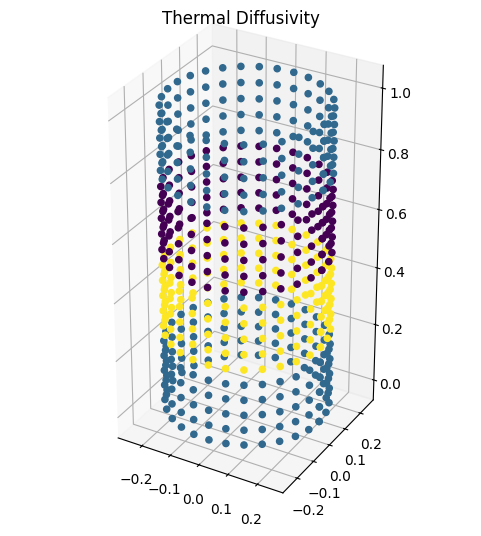

In [5]:
%matplotlib inline

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
 
neighbors = pringle.edge_index[0][950:955].tolist()
colors = np.zeros(pringle.idx)
colors[neighbors] = 1

# Creating plot
ax.scatter3D(pringle.x, pringle.y, pringle.z, c = pringle.a, alpha=1)
plt.title("Thermal Diffusivity")
plt.gca().set_aspect('equal', adjustable='box')

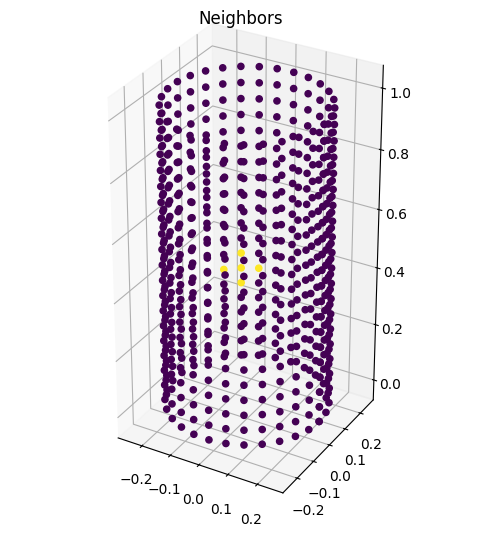

In [6]:
%matplotlib inline

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
 
neighbors = pringle.edge_index[0][950:955].tolist()
colors = np.zeros(pringle.idx)
colors[neighbors] = 1

# Creating plot
ax.scatter3D(pringle.x, pringle.y, pringle.z, c = colors, alpha=1)
plt.title("Neighbors")
plt.gca().set_aspect('equal', adjustable='box')

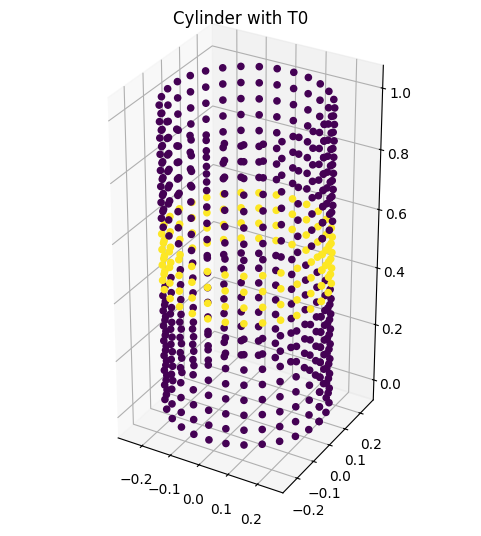

In [7]:
%matplotlib inline

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pringle.x, pringle.y, pringle.z, c = pringle.T0, alpha=1)
plt.title("Cylinder with T0")
plt.gca().set_aspect('equal', adjustable='box')

# Dataset and DataLoader 

In [8]:
class ShapeDataset(Dataset):
    def __init__(self, data, num_nodes, num_timesteps):
        self.data = data
        self.num_nodes = int(num_nodes)
        self.num_timesteps = int(num_timesteps)

    def __len__(self):
        return self.num_timesteps
    
    def __getitem__(self,i):
        start_idx = i*self.num_nodes
        stop_idx = (i+1)*self.num_nodes
        return self.data[start_idx:stop_idx]
    
train_dataset = ShapeDataset(pringle.data, num_nodes, num_timesteps)
train_dataloader = DataLoader(train_dataset, shuffle=False)

# Model

In [12]:
class GATModel(torch.nn.Module):
    def __init__(self, num_nodes, edge_index, heads=3, hidden_dim=256):
        """
        n = number timesteps
        k = number sensors
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.edge_index = edge_index
        self.hidden_dim = hidden_dim
        self.heads = heads
        self.norm = nn.LayerNorm(4)
        self.fc1 = nn.Linear(4, hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim*3, hidden_dim, heads=heads)
        self.gat3 = GATConv(hidden_dim*3, hidden_dim, heads=heads)
        self.gat4 = GATConv(hidden_dim*3, 1, heads=heads, concat=False)
        self.fc2 = nn.Linear(hidden_dim*heads, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        #x = self.norm(x)
        x = self.fc1(x)
        x = self.gat_layer1(x)
        x = self.relu(x)
        x = self.gat_layer2(x)
        x = self.relu(x)
        x = self.gat_layer3(x)
        x = self.relu(x)
        x = self.gat_layer4(x)

        return x
    
    def gat_layer1(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat1(data.x, data.edge_index)
        return x      
    def gat_layer2(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat2(data.x, data.edge_index)
        return x      
    def gat_layer3(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat3(data.x, data.edge_index)
        return x      
    def gat_layer4(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat4(data.x, data.edge_index)
        return x      
    

# Loss Function

In [13]:
def total_loss(u,u0,data,shape):
    u_d = torch.autograd.grad(torch.sum(u), data, retain_graph=True, create_graph=True)[0]
    u_dd = torch.autograd.grad(torch.sum(u_d), data, retain_graph=True, create_graph=True)[0]
    
    u_x = u_d[:,0]
    u_y = u_d[:,1]
    u_z = u_d[:,2]
    u_t = u_d[:,3]

    u_xx = u_dd[:,0]
    u_yy = u_dd[:,1]
    u_zz = u_dd[:,2]
    
    a = torch.tensor(shape.a)
    T0 = torch.tensor(shape.T0)
    
    # u_tt = c^2 * u_xx
    pde_loss = (a*u_xx + a*u_yy + a*u_zz - u_t)**2       

    # u0 = u_0 -> model(x,0) = u_0
    ic_loss_u = (T0 - u0)**2
    total_loss = (3/8)*pde_loss + (5/8)*ic_loss_u

    return torch.sum(total_loss)

# Training

In [14]:
model = GATModel(num_nodes, torch.tensor(pringle.edge_index), hidden_dim=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
EPOCH=100
for epoch in range(EPOCH):
    for i,item in enumerate(train_dataloader):
        data = item.squeeze().clone()
        data = torch.hstack((data[:,0:3],data[:,4].reshape(-1,1)))
        data = data.requires_grad_(True)

        data0 = item.squeeze().clone()
        data0 = torch.hstack((data0[:,0:3],torch.zeros(num_nodes).reshape(-1,1)))
        data0 = data0.requires_grad_(True)

        optimizer.zero_grad()
        u = model(data)
        u0 = model(data0)

        loss=total_loss(u,u0.squeeze(),data,pringle)   
        if i%5==0:
            print("epoch: ", epoch, ", timestep: ", i, ", loss: ", loss.item())    
        loss.backward()
        optimizer.step()    

epoch:  0 , timestep:  0 , loss:  276.8691273167866
epoch:  0 , timestep:  5 , loss:  250.88731865729437
epoch:  0 , timestep:  10 , loss:  238.3992666666391
epoch:  0 , timestep:  15 , loss:  235.03945774696493
epoch:  0 , timestep:  20 , loss:  231.39879401083087
epoch:  0 , timestep:  25 , loss:  226.69069858054536
epoch:  0 , timestep:  30 , loss:  221.96768139316268
epoch:  0 , timestep:  35 , loss:  216.37793937936988
epoch:  0 , timestep:  40 , loss:  210.458786274219
epoch:  0 , timestep:  45 , loss:  203.8771873061193
epoch:  0 , timestep:  50 , loss:  196.61507171847828
epoch:  0 , timestep:  55 , loss:  188.55790252419905
epoch:  1 , timestep:  0 , loss:  180.6385029253517
epoch:  1 , timestep:  5 , loss:  169.93257421240992
epoch:  1 , timestep:  10 , loss:  159.62952680415938
epoch:  1 , timestep:  15 , loss:  149.6135207049126
epoch:  1 , timestep:  20 , loss:  139.9923836781938
epoch:  1 , timestep:  25 , loss:  131.03290314646188
epoch:  1 , timestep:  30 , loss:  123.6

KeyboardInterrupt: 

In [15]:
del train_dataset
del train_dataloader

# Evaluation

In [16]:
eval_dataset = ShapeDataset(pringle.data, num_nodes, num_timesteps)
eval_dataloader = DataLoader(eval_dataset, shuffle=False)

In [17]:
temps = []

for data in eval_dataloader:
    data = data.squeeze().clone()
    data = torch.hstack((data[:,0:3],data[:,4].reshape(-1,1)))
    temp = model(data).detach().numpy()
    temps.append(temp)


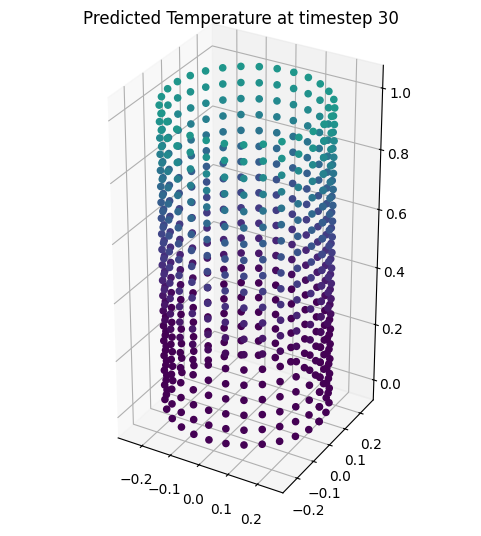

In [26]:
%matplotlib inline

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")

# Creating plot
timestep=30
ax.scatter3D(pringle.x, pringle.y, pringle.z, c = temps[timestep], alpha=1, vmin=0, vmax=2)
plt.title(f"Predicted Temperature at timestep {timestep}")
plt.gca().set_aspect('equal', adjustable='box')

In [27]:
import pickle

with open("test", "wb") as fp:   #Pickling
    pickle.dump(temps, fp)
with open("test", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

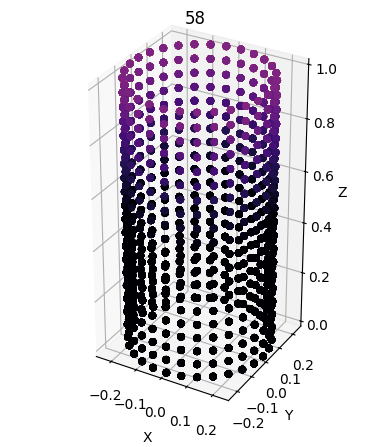

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[],alpha=1)
title = ax.set_title("Predicted Temperature")
cmap = sns.color_palette("magma", as_cmap=True)
max_temp = 2

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.25,0.25)
ax.set_ylim(-0.25,0.25)
ax.set_zlim(0,1)

def update(i):
    face_colors = cmap(temps[i]/max_temp)
    sc = ax.scatter(pringle.x,pringle.y,pringle.z, facecolors=face_colors)
    title.set_text(i)
    ax.set_box_aspect([ub-lb for lb,ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
    return sc,
    
ani = matplotlib.animation.FuncAnimation(fig, update, frames=59, blit=True, interval=500)
ani.save('cylinder_no_ffn.gif', writer=PillowWriter(fps=10))

plt.gca().set_aspect('equal', adjustable='box')
plt.show()